In [422]:
import skrf as rf
from skrf.constants import K_BOLTZMANN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.interpolate import interp1d
from devices.devices_lib import make_cavity__with_antennas_network # From Chirstan Boutan's PNNL team
import components as cmp # From Jihee
import os.path

%matplotlib inline

In [423]:
freq = rf.frequency.Frequency(start=0.4, stop=1.0, npoints=1001, unit='ghz', sweep_type='lin')
Troom = 290

# Component Functions

In [424]:
###############################
##### Component Functions   ###
###############################
#(From Jihee's components.py and analyis_run1C_tsys.py)

pow_to_dbm = lambda x: 10*np.log(x/1e-3)

### Function to read network in noisy environment ###
def read_in_noisy_network(ntw,freq_interp,Tphys):
    ntw_interp = ntw.interpolate(freq_interp, kind='cubic')
    ntw_interp_noisy = rf.NoisyNetwork(ntw_interp)
    ntw_interp_noisy.noise_source(source='passive',T0 = Tphys)

    return ntw_interp_noisy

### Function to make coaxial cable with coaxial line and SMA connector sample ###
def make_coax_cable(c_type,freq,len_m,Tphys):
        
    if c_type=='RG405U':
        ntw_coax_RT = cmp.cable_RG405U(freq,len_m)     #! replace cables with room temp, right type
        ntw_coax_cryo = cmp.RT2Cryo(ntw_coax_RT)
        # ntw_coax_cryo = ntw_coax_RT
        # ntw_SMA_RT = cmp.cable_RG405U(freq,0.04)
        ntw_SMA_RT = cmp.SMA_RG405U(freq,0.015)
        ntw_SMA_cryo = cmp.RT2Cryo(ntw_SMA_RT)
        # ntw_SMA_cryo = ntw_SMA_RT
    elif c_type=='PESR405FL':    
        ntw_coax_RT = cmp.cable_PESR405FL(freq,len_m)
        ntw_coax_cryo = cmp.RT2Cryo(ntw_coax_RT)
        # ntw_coax_cryo = ntw_coax_RT
        # ntw_SMA_RT = cmp.cable_PESR405FL(freq,0.04)
        ntw_SMA_RT = cmp.SMA_PESR405FL(freq,0.015)
        ntw_SMA_cryo = cmp.RT2Cryo(ntw_SMA_RT)
        # ntw_SMA_cryo = ntw_SMA_RT
    elif c_type=='NbTi085':
        ntw_coax_cryo = cmp.cable_NbTi085(freq,len_m)
        ntw_SMA_cryo = cmp.cable_NbTi085(freq,0.015)
    else:
        print('Error: Proper cable type is missing')

    noisy_ntw_coax = read_in_noisy_network(ntw_coax_cryo,freq,Tphys)
    noisy_ntw_SMA = read_in_noisy_network(ntw_SMA_cryo, freq, Tphys)
    
    assmb_cable = rf.MultiNoisyNetworkSystem()

    noisy_ntw_SMA.add_noise_polar(1e-6, 0.5)
    assmb_cable.add(noisy_ntw_SMA,'SMA1')
    assmb_cable.add(noisy_ntw_coax,'coax')
    noisy_ntw_SMA.add_noise_polar(1e-6, 0.55)
    assmb_cable.add(noisy_ntw_SMA,'SMA2')

    assmb_cable.connect('SMA1',2, 'coax',1)
    assmb_cable.connect('coax',2, 'SMA2',1)

    assmb_cable.external_port('SMA1',1,1)
    assmb_cable.external_port('SMA2',2,2)

    noisy_ntw_cable = assmb_cable.reduce()
    noisy_ntw_cable = read_in_noisy_network(noisy_ntw_cable,freq,Tphys)
        
    return noisy_ntw_cable  

# Creating amplifier from datasheet
Code from Jihee

In [425]:

# Creates a function of frequency that returns amplifier noise figure amplitudu
def gen_ZX60_33LN_S_NF_func(ZX60_33LN_NF_loc):
    
    # read in nf data from a csv
    # convert noise figure in db to amplitude
    # Make a new column with frequency in GHz
    # Interpolate noise figure as a function of frequency
    
    noise_figure_data2 = pd.read_csv(ZX60_33LN_NF_loc , header = 'infer')
    noise_figure_data2['NF Amplitude'] = 10**(noise_figure_data2['Noise Figure (5V)']/10)
    noise_figure_data2['Frequency (GHz)'] = noise_figure_data2['Frequency (MHz)']/1e3
    NF_Func2 = interp1d(noise_figure_data2['Frequency (GHz)'],noise_figure_data2['NF Amplitude'])#,fill_value=1000) # <- extrapolate ok here?
    
    return NF_Func2

def return_ZX60_33LN_params(Amp_path,Amp_name,freq,sat_check=False,vendor=True,Temp=290):
    
    # create amplifier from manufacturer's s2p file
    
    ZX60_33LN_NF_loc = r'/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data/ZX60-33LN_NF.csv'
    
    Tphys = Temp
    
    Amp_loc = os.path.join(Amp_path,Amp_name)
    amp_sparam = rf.Network(Amp_loc)
    amp_sparam = amp_sparam.interpolate(freq,kind='cubic')
    amp_sparam  = rf.NoisyNetwork(amp_sparam)
    amp_sparam.noise_source(source='passive',T0=Tphys) # <-- why do we need this is we are specifying the cs matrix from the datasheet?
    
    # generate noise figure function
    
    try:
        NF_func = gen_ZX60_33LN_S_NF_func(ZX60_33LN_NF_loc)
        nfig = NF_func(freq.f/1e9)
    except:
        print('error')
        return
    
    # use noise figure function to specify noise covariance matrix
    # cs}_ii = k_B T_0 S A S^dagger }_ii (F_i - 1)
        
    Tnoise = rf.NetworkNoiseCov.Tnoise(freq.f,Tphys) # <-- where is this noise temperature used?
    
    I = np.identity(np.shape(amp_sparam.s)[1])
    AS = np.matmul(I,np.conjugate(amp_sparam.s.swapaxes(1,2)))
    SAS = np.matmul(amp_sparam.s,AS)
    
    amp_sparam.cs[:,0,0] = (nfig - 1) * K_BOLTZMANN * 290 * SAS[:,0,0]
    
    I = np.identity(np.shape(amp_sparam.s)[1])
    AS = np.matmul(I,np.conjugate(amp_sparam.s.swapaxes(1,2)))
    SAS = np.matmul(amp_sparam.s,AS)
    
    amp_sparam.cs[:,1,1] = (nfig-1) * K_BOLTZMANN * 290 * SAS[:,1,1]
    
    amp_sparam.cs[:,0,1] = np.zeros_like(amp_sparam.cs[:,1,1])
    amp_sparam.cs[:,1,0] = amp_sparam.cs[:,0,1]
    
    return amp_sparam
    

# Assembling Network

In [439]:

### Plotting Cs matrix for cavity to second circulator for a list of terminator temperatures

T_SA = power_in_dBm_per_Hz_to_temp(-148.253) # <- Measured noise in dBm/Hz from spectrum analyzer with amplifiers off

def plot_cs_simple_circuit(termi_temps):
    
    for termi_temp in termi_temps:
        # Plot the power spectrum for the simple circuit setup in the lab. 
       
    
        #Terminator
        ntw_termi = cmp.create_terminator(freq,Gamma_0=0.048) # what is our terminator gamma_0?
        noisy_ntw_termi = read_in_noisy_network(ntw_termi, freq, termi_temp)

        
        #Cables
        LEN_CABLE1 = 0.3 #m
        LEN_CABLE2 = 0.3 #m

        noisy_ntw_cable_1 = make_coax_cable('RG405U',freq,LEN_CABLE1,Troom) # <--- cable noise?
        noisy_ntw_cable_2 = make_coax_cable('RG405U',freq,LEN_CABLE2,Troom)
        
        
        #Amplifier
        amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
        amp_name = 'ZX60-33LNR-S+_UNIT1_.s2p'

        amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)
    
        amp1 = amp_sparam
        amp2 = amp_sparam

        
        # Assemble circuit
        # terminator -> cable 1 -> amp 1 -> amp 2 -> cable 2 -> Spectrum analyzer
        mnns_simple_circ = rf.MultiNoisyNetworkSystem()

        mnns_simple_circ.add(noisy_ntw_cable_1,'cable1')
        mnns_simple_circ.add(noisy_ntw_cable_2,'cable2')
        mnns_simple_circ.add(noisy_ntw_termi,'termi')
        mnns_simple_circ.add(amp1,'amp1')
        mnns_simple_circ.add(amp2,'amp2')

        mnns_simple_circ.connect('termi',1,'cable1',1)
        mnns_simple_circ.connect('cable1',2,'amp1',1)
        mnns_simple_circ.connect('amp1',2,'amp2',1)
        mnns_simple_circ.connect('amp2',2,'cable2',1)

        mnns_simple_circ.external_port('cable2',2,1)

        assem_simple_circ = mnns_simple_circ.reduce()
        
        
        # Extract Noise temperature
        ## Formula from Garcia paper
        
        SAS = np.matmul(assem_simple_circ.s,np.conjugate(np.swapaxes(assem_simple_circ.s,1,2)))
        # print(assem_simple_circ.s)
        # print(np.swapaxes(assem_simple_circ.s,1,2))
        # print(SAS.shape)
        # print(assem_simple_circ.cs.shape)
        T_n_simple_circ  = (1/(K_BOLTZMANN))*assem_simple_circ.cs[:,0,0]/SAS[:,0,0] + T_SA # Te = 1/k_B * ( Cs / |s11|^2 ) <-- from formula for Cs.
        
        print(termi_temp,'K: ',T_n_simple_circ[-1]/1e9,'1e9')
        
        
        # Plot noise temperature vs. frequency
        plt.xlim(990,1000)
        plt.plot(freq.f/1e6,T_n_simple_circ,label=termi_temp)
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Noise temp [K]')
        plt.title(f' Simple Circuit \n noise temperature')
        plt.tight_layout(pad=0.3, w_pad=0.2, h_pad=0.2)
        plt.legend()
        
    # plot measured SA background noise temp
    plt.plot(freq.f/1e6, T_SA*np.ones_like(freq.f),label='SA')
    
    

        



290 K:  (1.6473947858000786-4.395256383136972e-17j) 1e9
77 K:  (0.7040415736611528+1.6595164611577582e-17j) 1e9


/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


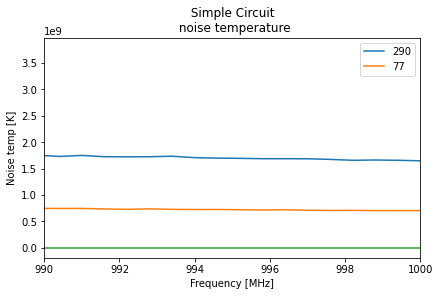

In [440]:

plot_cs_simple_circuit([290,77])

# Measured Values

In [428]:

dBm_to_W = lambda p_dBm: 10**(p_dBm/10)/1000
power_in_dBm_per_Hz_to_temp = lambda p: dBm_to_W(p)/K_BOLTZMANN

# noise power was measured at 1 Ghz over 1 Hz bandwidth (in dBm / Hz)

print('SA (amp off): ',round(power_in_dBm_per_Hz_to_temp(-148.253)/1e9,5),'1e9 K' )
print('T_termi = 290K: ',round(power_in_dBm_per_Hz_to_temp(-135.15)/1e9,5), '1e9 K')
print('T_termi = 77K: ',round(power_in_dBm_per_Hz_to_temp(-138.611)/1e9,6), '1e9 K')


SA (amp off):  0.00011 1e9 K
T_termi = 290K:  0.00221 1e9 K
T_termi = 77K:  0.000997 1e9 K


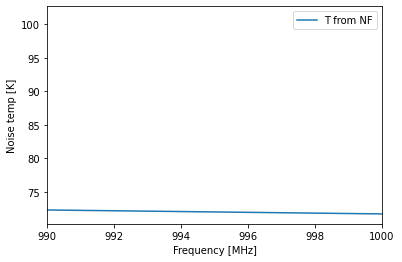

In [429]:

ZX60_33LN_NF_loc = r'/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data/ZX60-33LN_NF.csv'
NF_func = gen_ZX60_33LN_S_NF_func(ZX60_33LN_NF_loc)
nfig = NF_func(freq.f/1e9)
plt.xlim(990,1000)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Noise temp [K]')
plt.plot(freq.f/1e6, (nfig-1)*290,label='T from NF')
plt.legend()

In [430]:
freq.f

array([4.000e+08, 4.006e+08, 4.012e+08, ..., 9.988e+08, 9.994e+08,
       1.000e+09])

In [431]:
noise_figure_data2 = pd.read_csv(ZX60_33LN_NF_loc , header = 'infer')
noise_figure_data2
noise_figure_data2['NF Amplitude'] = 10**(noise_figure_data2['Noise Figure (5V)']/10)
noise_figure_data2['Frequency (GHz)'] = noise_figure_data2['Frequency (MHz)']/1e3
NF_Func2 = interp1d(noise_figure_data2['Frequency (GHz)'],noise_figure_data2['NF Amplitude'])#,fill_value='extrapolate') # <- extrapolate ok here?
    
noise_figure_data2

,Frequency (MHz),Noise Figure (3V),Noise Figure (5V),NF Amplitude,Frequency (GHz)
0,50,1.26,1.60,1.445440,0.05
1,100,0.96,1.11,1.291219,0.10
2,200,1.09,0.97,1.250259,0.20
3,300,0.90,0.98,1.253141,0.30
4,400,0.92,0.99,1.256030,0.40
5,500,0.92,1.01,1.261828,0.50
6,600,0.94,1.04,1.270574,0.60
7,700,1.20,1.30,1.348963,0.70
8,800,0.95,1.04,1.270574,0.80
9,900,0.95,1.03,1.267652,0.90


In [432]:
NF_func = gen_ZX60_33LN_S_NF_func(ZX60_33LN_NF_loc)
NF_func((50/1e3))
NF_func(1200/1e3)

array(1.24623595)

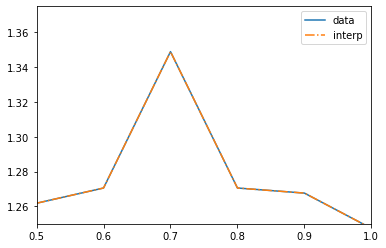

In [433]:
plt.xlim(0.5,1)
plt.ylim(1.250,1.375)
plt.plot(noise_figure_data2['Frequency (GHz)'],noise_figure_data2['NF Amplitude'],label='data')
plt.plot(freq.f/1e9,NF_func(freq.f/1e9),'-.',label='interp')
plt.legend()

/Users/zacharybanken/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


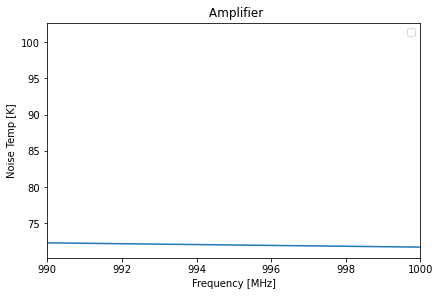

In [434]:
SAS = np.matmul(amp_sparam.s,np.conjugate(np.swapaxes(amp_sparam.s,1,2)))
plt.plot(freq.f/1e6, amp_sparam.cs[:,1,1] / ( K_BOLTZMANN * SAS[:,1,1] ) ) 
plt.xlim(990,1000)
plt.xlabel('Frequency [MHz]')
plt.ylabel('Noise Temp [K]')
plt.title(f' Amplifier')
plt.legend()
plt.tight_layout(pad=0.3, w_pad=0.2, h_pad=0.2)

In [435]:
amp_sparam.s[:,0,0]

array([-0.18385701-0.41037168j, -0.18476696-0.41005625j,
       -0.18566298-0.40974142j, ..., -0.43559228+0.16053381j,
       -0.43537387+0.16101695j, -0.43515464+0.16149894j])

In [436]:
noisy_ntw_cable_1 = make_coax_cable('RG405U',freq,0.3,Troom)

I = np.identity(np.shape(noisy_ntw_cable_1.s)[1])
AS = np.matmul(I,np.conjugate(noisy_ntw_cable_1.s.swapaxes(1,2)))
SAS = np.matmul(noisy_ntw_cable_1.s,AS)

Tcable = noisy_ntw_cable_1.cs[:,1,1]/( K_BOLTZMANN * SAS[:,1,1] )
Tcable[-1]

(8.123441810123602+5.66593410190794e-16j)

In [437]:
I = np.identity(np.shape(noisy_ntw_cable_1.s)[1])
AS = np.matmul(I,np.conjugate(noisy_ntw_cable_1.s.swapaxes(1,2)))
SAS = np.matmul(noisy_ntw_cable_1.s,AS)

Tcable = noisy_ntw_cable_1.cs[:,1,1]/( K_BOLTZMANN * SAS[:,1,1] )
print('cable noise temp: ',Tcable[-1])

cable noise temp:  (8.123441810123602+5.66593410190794e-16j)


In [438]:
amp_path = '/Users/zacharybanken/Desktop/research_stuff/Terminator_Temp_Test/amplifier_data'
amp_name = 'ZX60-33LNR-S+_UNIT2_.s2p'

amp_sparam = return_ZX60_33LN_params(amp_path,amp_name,freq)

def get_T(ntw):

    I = np.identity(np.shape(ntw.s)[1])
    AS = np.matmul(I,np.conjugate(ntw.s.swapaxes(1,2)))
    SAS = np.matmul(ntw.s,AS)

    Tntw = ntw.cs[:,1,1]/( K_BOLTZMANN * SAS[:,1,1] )
    
    print(Tntw[-1])

print('amp noise temp:')
get_T(amp_sparam)

ntw_termi = cmp.create_terminator(freq,Gamma_0=0.048) # what is our terminator gamma_0?
noisy_ntw_termi = read_in_noisy_network(ntw_termi, freq, 300)
    
    
I = np.identity(np.shape(noisy_ntw_termi.s)[1])
AS = np.matmul(I,np.conjugate(noisy_ntw_termi.s.swapaxes(1,2)))
SAS = np.matmul(noisy_ntw_termi.s,AS)

Tntw = noisy_ntw_termi.cs[:,0,0]/( K_BOLTZMANN * SAS[:,0,0] )
    
print('Termi Noise temp: ',Tntw[-1])


amp noise temp:
(71.74121913045347+0j)
Termi Noise temp:  (129908.33361038388+0j)
